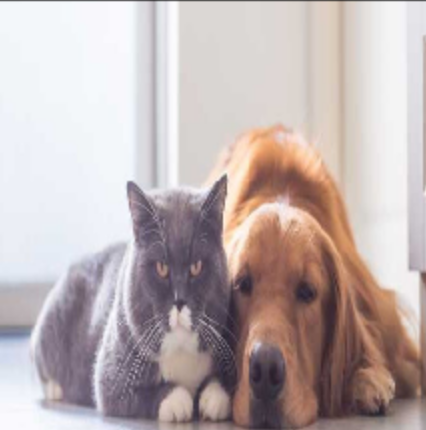

In [1]:
from IPython.display import Image, display

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

## The local path to our target image

img_path= "dog_and_cat.png"

display(Image(img_path))
def get_img_array(img_path, size):
    ## `img` is a PIL image
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    ## We add a dimension to transform our array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    ## First, we create a model that maps the input image to the activations
    ## of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    ## Then, we compute the gradient of the top predicted class for our input image
    ## for the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    ## We are doing transfer learning on last layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    ## This is a vector where each entry is the mean intensity of the gradient
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    ## calculates a heatmap highlighting the regions of importance in an image
    ## for a specific
    ## predicted class by combining the output of the last convolutional layer
    ## with the pooled gradients.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    ## For visualization purpose
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

35363/35363 [==============================] - 0s 0us/step
Predicted of image: [('n02099601', 'golden_retriever', 6.8081255)]


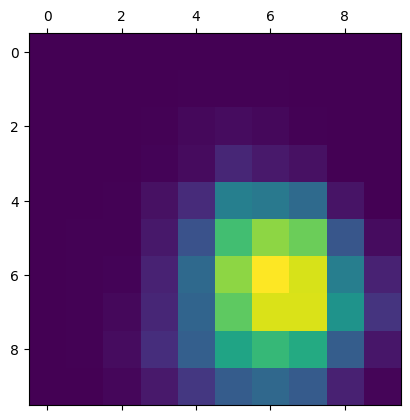

In [2]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))

## Making the model with imagenet dataset
model = model_builder(weights="imagenet")

## Remove last layer's softmax(transfer learning)
model.layers[-1].activation = None

preds = model.predict(img_array)
print("Predicted of image:", decode_predictions(preds, top=1)[0])

## Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

## visulization of heatmap
plt.matshow(heatmap)
plt.show()

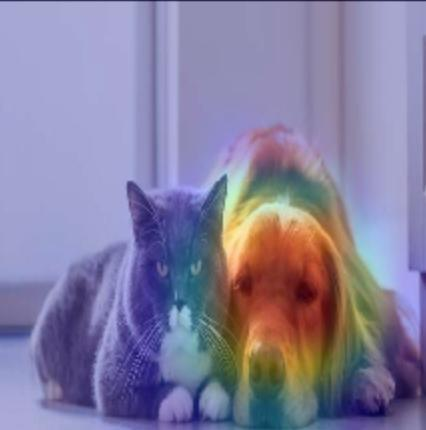

In [3]:
def save_and_display_gradcam(img_path, heatmap, cam_path="save_cam_image.jpg", alpha=0.4):
    ## Loading the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    ## Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    ## Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    ## Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    ## Superimpose the heatmap on original image
    Superimposed_img = jet_heatmap * alpha + img
    Superimposed_img = keras.utils.array_to_img(Superimposed_img)

    ## Save the superimposed image
    Superimposed_img.save(cam_path)

    ## Displaying Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)